<a href="https://colab.research.google.com/github/tomonari-masada/course2024-sml/blob/main/04_nearest_neighbors_1_(example).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k近傍法 (k-nearest neighbors)
* 直感的には、「どんな友人と付き合っているかを見ればその人が分かる」という考え方にもとづく手法。
  * 近いものは同類、という考え方。
* 分類にも回帰にも使える。
  * 分類＝未知のデータ点について、それが属するクラスを予測
  * 回帰＝未知のデータ点について、対応する特定の数値を予測
* 新しいデータ点について、対応するターゲット（クラス or 数値）を予測する場合・・・
* k近傍法では、そのデータ点のk個の近傍のターゲットを元に予測する。
  * クラスを予測する（分類）の場合、予測は多数決で行われる。
  * 数値を予測する（回帰）の場合、近傍のターゲットの値の平均を予測値とする。（平均値以外もありうる。）

## 準備

### インポート

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

### データファイル


* `lifesat_extended.csv`というファイルをColabにアップロードする。

In [3]:
from google.colab import files
files.upload()

Saving lifesat_extended.csv to lifesat_extended.csv


{'lifesat_extended.csv': b'Country,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,Housing expenditure,Job security,Life expectancy,Life satisfaction,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,GDP per capita\nRussia,15.0,3.8,2.5,15.1,94.0,0.16,69.0,12.8,19292.0,3412.0,11.0,4.0,70.2,6.0,1.7,20885.0,90.0,0.9,37.0,481.0,14.97,65.0,56.0,16.0,9054.914\nTurkey,35.0,5.0,5.5,12.7,34.0,40.86,50.0,1.2,14095.0,3251.0,21.0,8.1,74.6,5.6,2.37,16919.0,86.0,1.1,68.0,462.0,13.42,88.0,62.0,16.4,9437.372\nHungary,15.0,3.6,7.9,4.8,82.0,3.19,58.0,1.3,15442.0,13277.0,20.0,5.7,75.2,4.9,5.1,20948.0,87.0,1.1,57.0,487.0,15.04,62.0,77.0,17.6,1223

* 国名をインデックスにしてデータフレームを作る。

In [4]:
df = pd.read_csv("lifesat_extended.csv", index_col="Country")
df

,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,GDP per capita
Country,,,,,,,,,,,,,,,,,,,,,
Russia,15.0,3.8,2.5,15.1,94.0,0.16,69.0,12.8,19292.0,3412.0,...,20885.0,90.0,0.9,37.0,481.0,14.97,65.0,56.0,16.0,9054.914
Turkey,35.0,5.0,5.5,12.7,34.0,40.86,50.0,1.2,14095.0,3251.0,...,16919.0,86.0,1.1,68.0,462.0,13.42,88.0,62.0,16.4,9437.372
Hungary,15.0,3.6,7.9,4.8,82.0,3.19,58.0,1.3,15442.0,13277.0,...,20948.0,87.0,1.1,57.0,487.0,15.04,62.0,77.0,17.6,12239.894
Poland,33.0,1.4,10.8,3.2,90.0,7.41,60.0,0.9,17852.0,10919.0,...,22655.0,91.0,1.1,58.0,521.0,14.20,55.0,79.0,18.4,12495.334
Slovak Republic,13.0,3.0,6.6,0.6,92.0,7.02,60.0,1.2,17503.0,8663.0,...,20307.0,90.0,1.1,66.0,472.0,14.99,59.0,81.0,16.3,15991.736
Estonia,9.0,5.5,3.3,8.1,90.0,3.30,68.0,4.8,15167.0,7680.0,...,18944.0,89.0,1.5,54.0,526.0,14.90,64.0,79.0,17.5,17288.083
Greece,27.0,3.7,6.5,0.7,68.0,6.16,49.0,1.6,18575.0,14579.0,...,25503.0,83.0,1.2,74.0,466.0,14.91,64.0,69.0,18.6,18064.288
Portugal,18.0,5.7,6.5,0.9,38.0,9.62,61.0,1.1,20086.0,31245.0,...,23688.0,86.0,1.6,46.0,488.0,14.95,58.0,86.0,17.6,19121.592
Slovenia,26.0,3.9,10.3,0.5,85.0,5.63,63.0,0.4,19326.0,18465.0,...,32037.0,90.0,1.5,65.0,499.0,14.62,52.0,88.0,18.4,20732.482


## 今回の問題設定
* この授業では、以下の二つを、予測のための特徴量(feature)として使うことにする。
  * 国民一人当たりのGDP (GDP per capita)
  * 雇用率 (employment rate)
* 予測するターゲットは、生活満足度 (life satisfaction) とする。
* そして、最終的に予測したいのは、日本の生活満足度だとする。
  * もちろん、すでに答えは分かっているが、最後まで正解は伏せておく。


* 言い換えれば、日本のデータが、テストデータとなる。
  * テストデータ＝最終的に手法の性能を評価するために使うデータ集合。
* テストデータでの評価結果を見て、手法をチューニングしてはいけないです！
  * 機械学習の基本中の基本。
* そこで、日本を除外したデータフレームを作り、それを使う。
  * 日本のデータは、最後の最後に、手法評価時に使うだけ。

* （ちょっとコメント）
  * 普通は、テストデータは今回のように一つだけではなく、複数のインスタンスを用意する。
  * 今回は、全体のデータ数が29個と少ないため、テストデータは一つだけにしている。

In [5]:
df_train = df.drop(['Japan'])
df_test = df.loc[['Japan']]

* 訓練データのさまざまな情報を確認する。

In [ ]:
df_train

,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,GDP per capita
Country,,,,,,,,,,,,,,,,,,,,,
Russia,15.0,3.8,2.5,15.1,94.0,0.16,69.0,12.8,19292.0,3412.0,...,20885.0,90.0,0.9,37.0,481.0,14.97,65.0,56.0,16.0,9054.914
Turkey,35.0,5.0,5.5,12.7,34.0,40.86,50.0,1.2,14095.0,3251.0,...,16919.0,86.0,1.1,68.0,462.0,13.42,88.0,62.0,16.4,9437.372
Hungary,15.0,3.6,7.9,4.8,82.0,3.19,58.0,1.3,15442.0,13277.0,...,20948.0,87.0,1.1,57.0,487.0,15.04,62.0,77.0,17.6,12239.894
Poland,33.0,1.4,10.8,3.2,90.0,7.41,60.0,0.9,17852.0,10919.0,...,22655.0,91.0,1.1,58.0,521.0,14.20,55.0,79.0,18.4,12495.334
Slovak Republic,13.0,3.0,6.6,0.6,92.0,7.02,60.0,1.2,17503.0,8663.0,...,20307.0,90.0,1.1,66.0,472.0,14.99,59.0,81.0,16.3,15991.736
Estonia,9.0,5.5,3.3,8.1,90.0,3.30,68.0,4.8,15167.0,7680.0,...,18944.0,89.0,1.5,54.0,526.0,14.90,64.0,79.0,17.5,17288.083
Greece,27.0,3.7,6.5,0.7,68.0,6.16,49.0,1.6,18575.0,14579.0,...,25503.0,83.0,1.2,74.0,466.0,14.91,64.0,69.0,18.6,18064.288
Portugal,18.0,5.7,6.5,0.9,38.0,9.62,61.0,1.1,20086.0,31245.0,...,23688.0,86.0,1.6,46.0,488.0,14.95,58.0,86.0,17.6,19121.592
Slovenia,26.0,3.9,10.3,0.5,85.0,5.63,63.0,0.4,19326.0,18465.0,...,32037.0,90.0,1.5,65.0,499.0,14.62,52.0,88.0,18.4,20732.482


In [ ]:
df_train.describe()

,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,GDP per capita
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,...,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,19.071429,3.650000,7.246429,2.257143,76.500000,8.310714,65.678571,1.642857,24237.535714,40455.142857,...,36649.464286,90.107143,1.678571,69.000000,499.535714,14.888929,71.607143,82.821429,17.778571,33424.113571
std,7.297532,1.515231,2.768270,3.790674,14.977761,8.006786,7.841266,2.475723,6236.156042,30674.993066,...,11908.722948,4.878823,0.453266,14.100171,20.124579,0.561396,10.867346,10.811700,1.165351,14917.851426
min,9.000000,1.300000,2.500000,0.000000,34.000000,0.160000,49.000000,0.300000,14095.000000,3251.000000,...,16919.000000,72.000000,0.900000,35.000000,462.000000,13.420000,52.000000,56.000000,15.800000,9054.914000
25%,13.000000,2.350000,5.075000,0.200000,72.750000,3.640000,60.000000,0.600000,19317.500000,17493.500000,...,25049.250000,88.500000,1.350000,65.000000,486.250000,14.577500,64.000000,77.750000,16.950000,18857.266000
50%,17.000000,3.650000,7.050000,0.650000,80.000000,6.025000,67.000000,1.000000,23941.000000,37312.500000,...,38207.000000,90.000000,1.650000,70.500000,499.500000,14.905000,69.500000,85.500000,17.600000,37359.948500
75%,24.500000,4.925000,10.300000,2.300000,86.500000,11.537500,72.000000,1.325000,28430.000000,53446.500000,...,47080.750000,94.000000,1.925000,77.750000,515.250000,15.130000,77.750000,91.250000,18.625000,43735.695250
max,35.000000,6.600000,11.500000,15.100000,94.000000,40.860000,82.000000,12.800000,41355.000000,145769.000000,...,56340.000000,96.000000,2.500000,90.000000,542.000000,16.060000,93.000000,97.000000,19.800000,55805.204000


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, Russia to United States
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Air pollution                              28 non-null     float64
 1   Assault rate                               28 non-null     float64
 2   Consultation on rule-making                28 non-null     float64
 3   Dwellings without basic facilities         28 non-null     float64
 4   Educational attainment                     28 non-null     float64
 5   Employees working very long hours          28 non-null     float64
 6   Employment rate                            28 non-null     float64
 7   Homicide rate                              28 non-null     float64
 8   Household net adjusted disposable income   28 non-null     float64
 9   Household net financial wealth             28 non-null     float64
 10  Housing expenditu

* テストデータは、最後の最後に、チューニング済みの手法を評価する時まで、使わない。

* GDP per capitaやemployment rateを使って生活満足度を予測するという問題設定が、そもそも妥当な問題設定かどうか、確認する。
 * 特徴量とターゲットとのあいだに、ある程度の関連性がないと、解けない問題を解こうとしていることになる。

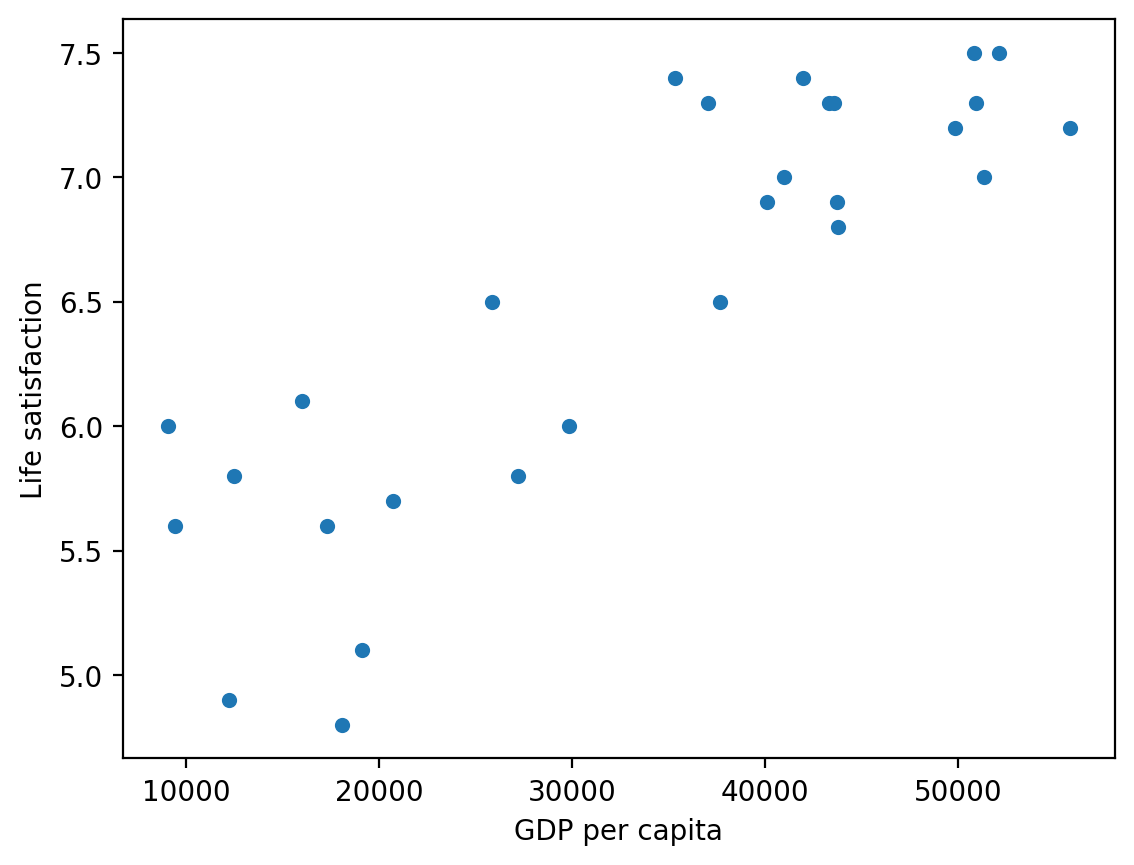

In [ ]:
df_train.plot(kind='scatter', x='GDP per capita', y='Life satisfaction');

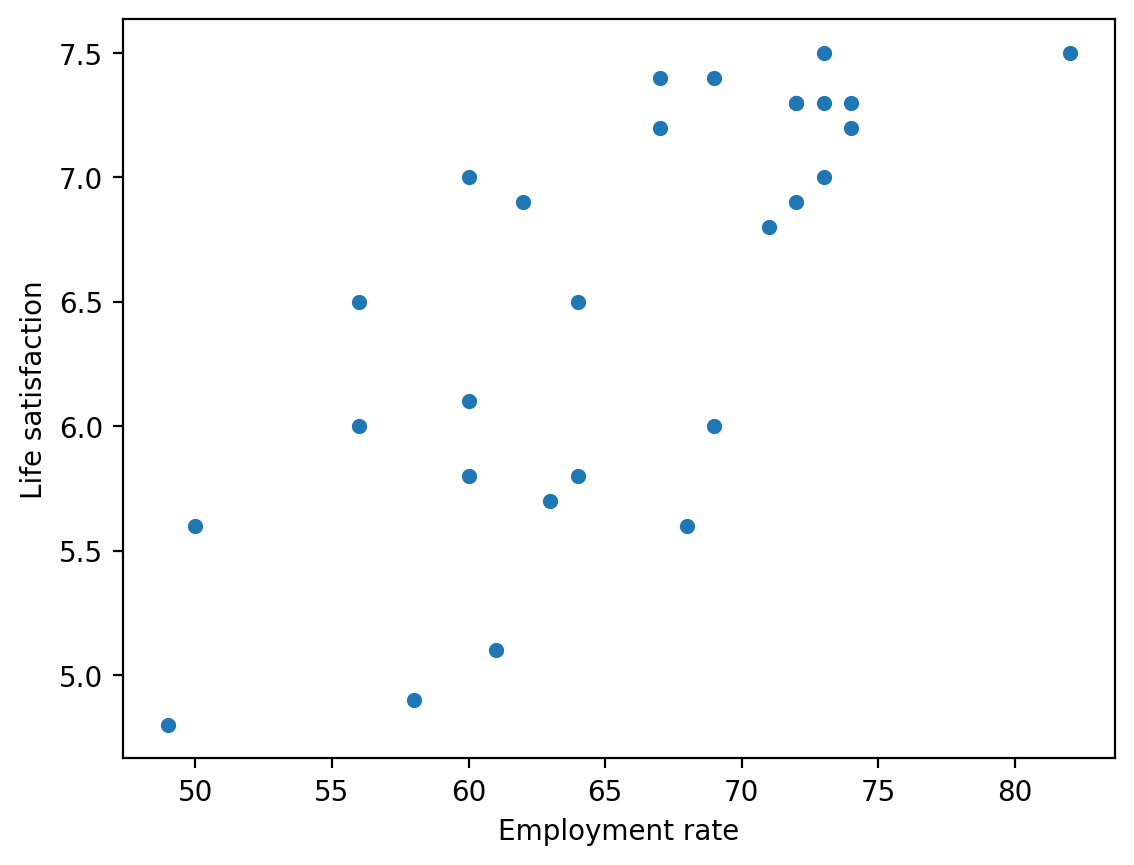

In [ ]:
df_train.plot(kind='scatter', x='Employment rate', y='Life satisfaction');

* まあ大丈夫そう。

### 特徴量とターゲットの用意

* 特徴量である(一人当たりのGDP, 雇用率)と、ターゲットである生活満足度とを、別々に保存する。

In [6]:
X = df_train[['GDP per capita', 'Employment rate']]
y = df_train['Life satisfaction']

In [ ]:
X

,GDP per capita,Employment rate
Country,,
Russia,9054.914,69.0
Turkey,9437.372,50.0
Hungary,12239.894,58.0
Poland,12495.334,60.0
Slovak Republic,15991.736,60.0
Estonia,17288.083,68.0
Greece,18064.288,49.0
Portugal,19121.592,61.0
Slovenia,20732.482,63.0


In [ ]:
y

Country
Russia             6.0
Turkey             5.6
Hungary            4.9
Poland             5.8
Slovak Republic    6.1
Estonia            5.6
Greece             4.8
Portugal           5.1
Slovenia           5.7
Spain              6.5
Korea              5.8
Italy              6.0
Israel             7.4
New Zealand        7.3
France             6.5
Belgium            6.9
Germany            7.0
Finland            7.4
Canada             7.3
Netherlands        7.3
Austria            6.9
United Kingdom     6.8
Sweden             7.2
Iceland            7.5
Australia          7.3
Ireland            7.0
Denmark            7.5
United States      7.2
Name: Life satisfaction, dtype: float64

## k近傍法の実装（k=1の場合）

* 以下では、例題として、韓国の生活満足度の予測を考える。
  * そして、テストデータ上での生活満足度の予測をうまくいかせるために・・・
  * k近傍法をどのように使えばよいか、チューニングしていく。

* 言い換えれば、韓国のデータが、検証データとなる。
  * 検証データも、普通は、複数インスタンスを用意する。

### k近傍法の実装の仕方
* k=1に設定してk近傍法を使うとはどういうことか？
  1. 韓国に最も近い国を求める。
  2. 韓国に最も近い国の生活満足度を、韓国の生活満足度の予測値とする。

* 韓国に最も近い国を、どうやって選べばいいだろうか？

In [ ]:
X.loc[['Korea']]

,GDP per capita,Employment rate
Country,,
Korea,27195.197,64.0


* なお、以下のようにすれば、インデックス、つまり国名を枚挙できる。

In [ ]:
for country in X.index:
  print(country)

Russia
Turkey
Hungary
Poland
Slovak Republic
Estonia
Greece
Portugal
Slovenia
Spain
Korea
Italy
Israel
New Zealand
France
Belgium
Germany
Finland
Canada
Netherlands
Austria
United Kingdom
Sweden
Iceland
Australia
Ireland
Denmark
United States


* 以下のようにすれば、各国の特徴量をNumpyの配列として枚挙できる。

In [ ]:
for country in X.index:
  print(X.loc[country].values)

[9054.914   69.   ]
[9437.372   50.   ]
[12239.894    58.   ]
[12495.334    60.   ]
[15991.736    60.   ]
[17288.083    68.   ]
[18064.288    49.   ]
[19121.592    61.   ]
[20732.482    63.   ]
[25864.721    56.   ]
[27195.197    64.   ]
[29866.581    56.   ]
[35343.336    67.   ]
[37044.891    73.   ]
[37675.006    64.   ]
[40106.632    62.   ]
[40996.511    73.   ]
[41973.988    69.   ]
[43331.961    72.   ]
[43603.115    74.   ]
[43724.031    72.   ]
[43770.688    71.   ]
[49866.266    74.   ]
[50854.583    82.   ]
[50961.865    72.   ]
[51350.744    60.   ]
[52114.165    73.   ]
[55805.204    67.   ]


* 以下、まずは簡単のため、雇用率はしばらく使わないことにし・・・
* 一人当たりのGDPだけを各国の特徴量として、生活満足度の予測を行うコードを書くことにする。

### 演習問題1
* 一人当たりのGDPが、韓国に最も近い国を求めてみよう。

In [ ]:
X_train = X.drop(['Korea'])
X_valid = X.loc['Korea']
y_train = y.drop(['Korea'])
y_valid = y['Korea']

In [ ]:
feature = X_train.columns[0]
k = 1
indices = (X_train[feature] - X_valid[feature]).abs().sort_values().index[0:k]
print(indices)

Index(['Spain'], dtype='object', name='Country')


### 演習問題2
* 上で求めた国の生活満足度を、韓国の生活満足度の予測値としたとき、予測誤差はいくらか。

In [ ]:
feature = X_train.columns[0]
k = 1
indices = (X_train[feature] - X_valid[feature]).abs().sort_values().index[0:k]
np.abs(y_train[indices].mean() - y_valid)

0.7000000000000002

## k近傍法の実装 （kの値が任意の場合）

* kの値が2以上の場合のk近傍法を実装する。
* そして、kの値がいくらのときに最も予測性能が良くなるかを調べることで・・・
* kの値をチューニングする。

### 演習問題3
* 全ての国について、一人当たりのGDPを使って計算される韓国との距離を求めよう。

In [ ]:
X_train = X.drop(['Korea'])
X_valid = X.loc['Korea']
y_train = y.drop(['Korea'])
y_valid = y['Korea']

feature = X_train.columns[0]
(X_train[feature] - X_valid[feature]).abs()

Country
Russia             18140.283
Turkey             17757.825
Hungary            14955.303
Poland             14699.863
Slovak Republic    11203.461
Estonia             9907.114
Greece              9130.909
Portugal            8073.605
Slovenia            6462.715
Spain               1330.476
Italy               2671.384
Israel              8148.139
New Zealand         9849.694
France             10479.809
Belgium            12911.435
Germany            13801.314
Finland            14778.791
Canada             16136.764
Netherlands        16407.918
Austria            16528.834
United Kingdom     16575.491
Sweden             22671.069
Iceland            23659.386
Australia          23766.668
Ireland            24155.547
Denmark            24918.968
United States      28610.007
Name: GDP per capita, dtype: float64

### 演習問題4
* 韓国の一人当たりのGDPに近い順に、他の全ての国を並べ替えて表示させよう。

In [ ]:
X_train = X.drop(['Korea'])
X_valid = X.loc['Korea']
y_train = y.drop(['Korea'])
y_valid = y['Korea']

feature = X_train.columns[0]
indices = (X_train[feature] - X_valid[feature]).abs().sort_values().index
print(indices)

Index(['Spain', 'Italy', 'Slovenia', 'Portugal', 'Israel', 'Greece',
       'New Zealand', 'Estonia', 'France', 'Slovak Republic', 'Belgium',
       'Germany', 'Poland', 'Finland', 'Hungary', 'Canada', 'Netherlands',
       'Austria', 'United Kingdom', 'Turkey', 'Russia', 'Sweden', 'Iceland',
       'Australia', 'Ireland', 'Denmark', 'United States'],
      dtype='object', name='Country')


### 演習問題5
* 変数kに近傍の個数が代入されている。韓国のk個の近傍の国名を、韓国に近い順に表示させよう。

In [ ]:
k = 5
feature = X_train.columns[0]
indices = (X_train[feature] - X_valid[feature]).abs().sort_values().index
print(indices[:k])

Index(['Spain', 'Italy', 'Slovenia', 'Portugal', 'Israel'], dtype='object', name='Country')


### 演習問題6
* 上で求めたk個の国について、それらの国の生活満足度の*平均値*を求めよう。

In [ ]:
k = 5
feature = X_train.columns[0]
indices = (X_train[feature] - X_valid[feature]).abs().sort_values().index
print(y_train[indices[:k]].mean())

6.139999999999999


### 演習問題7
* 上の平均値を、韓国の生活満足度の予測値とした場合、予測誤差はいくらか。

In [ ]:
k = 5
feature = X_train.columns[0]
indices = (X_train[feature] - X_valid[feature]).abs().sort_values().index
print(np.abs(y_train[indices[:k]].mean() - y_valid))

0.33999999999999897


# 課題

## 問1
* 変数kの値を、1から27まで変化させたとき、最も予測誤差が小さくなるのは、kの値がいくらのときか。

In [7]:
X_train = X.drop(['Korea'])
X_valid = X.loc['Korea']
y_train = y.drop(['Korea'])
y_valid = y['Korea']

In [8]:
feature = X_train.columns[0]
print(feature)

GDP per capita


In [14]:
X_train[feature]

Country
Russia              9054.914
Turkey              9437.372
Hungary            12239.894
Poland             12495.334
Slovak Republic    15991.736
Estonia            17288.083
Greece             18064.288
Portugal           19121.592
Slovenia           20732.482
Spain              25864.721
Italy              29866.581
Israel             35343.336
New Zealand        37044.891
France             37675.006
Belgium            40106.632
Germany            40996.511
Finland            41973.988
Canada             43331.961
Netherlands        43603.115
Austria            43724.031
United Kingdom     43770.688
Sweden             49866.266
Iceland            50854.583
Australia          50961.865
Ireland            51350.744
Denmark            52114.165
United States      55805.204
Name: GDP per capita, dtype: float64

In [15]:
(X_train[feature] - X_valid[feature]).abs().sort_values()

Country
Spain               1330.476
Italy               2671.384
Slovenia            6462.715
Portugal            8073.605
Israel              8148.139
Greece              9130.909
New Zealand         9849.694
Estonia             9907.114
France             10479.809
Slovak Republic    11203.461
Belgium            12911.435
Germany            13801.314
Poland             14699.863
Finland            14778.791
Hungary            14955.303
Canada             16136.764
Netherlands        16407.918
Austria            16528.834
United Kingdom     16575.491
Turkey             17757.825
Russia             18140.283
Sweden             22671.069
Iceland            23659.386
Australia          23766.668
Ireland            24155.547
Denmark            24918.968
United States      28610.007
Name: GDP per capita, dtype: float64

In [16]:
indices = (X_train[feature] - X_valid[feature]).abs().sort_values().index
print(indices)

Index(['Spain', 'Italy', 'Slovenia', 'Portugal', 'Israel', 'Greece',
       'New Zealand', 'Estonia', 'France', 'Slovak Republic', 'Belgium',
       'Germany', 'Poland', 'Finland', 'Hungary', 'Canada', 'Netherlands',
       'Austria', 'United Kingdom', 'Turkey', 'Russia', 'Sweden', 'Iceland',
       'Australia', 'Ireland', 'Denmark', 'United States'],
      dtype='object', name='Country')


In [17]:
len(indices)

27

In [20]:
y_train[indices[:3]].mean()

6.066666666666666

In [21]:
y_valid

5.8

In [28]:
prediction_errors = {}
for k in range(1, 28):
  prediction_errors[k] = np.abs(y_train[indices[:k]].mean() - y_valid)
k_best = sorted(prediction_errors.items(), key=lambda item: item[1])[0][0]
print(k_best)

4


* for文を使わない方法

In [36]:
(y_train[indices].cumsum() / (np.arange(len(y_train)) + 1) - y_valid).abs()

Country
Spain              0.700000
Italy              0.450000
Slovenia           0.266667
Portugal           0.025000
Israel             0.340000
Greece             0.116667
New Zealand        0.314286
Estonia            0.250000
France             0.300000
Slovak Republic    0.300000
Belgium            0.372727
Germany            0.441667
Poland             0.407692
Finland            0.492857
Hungary            0.400000
Canada             0.468750
Netherlands        0.529412
Austria            0.561111
United Kingdom     0.584211
Turkey             0.545000
Russia             0.528571
Sweden             0.568182
Iceland            0.617391
Australia          0.654167
Ireland            0.676000
Denmark            0.715385
United States      0.740741
Name: Life satisfaction, dtype: float64

In [33]:
np.arange(len(y_train)) + 1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [38]:
X_train.columns

Index(['GDP per capita', 'Employment rate'], dtype='object')

In [37]:
X_train = X.drop(['Korea'])
X_valid = X.loc['Korea']
y_train = y.drop(['Korea'])
y_valid = y['Korea']

feature = X_train.columns[0]
indices = (X_train[feature] - X_valid[feature]).abs().sort_values().index
(y_train[indices].cumsum() / (1 + np.arange(len(y_train))) - y_valid).abs().argmin() + 1

4

In [ ]:
(y_train[indices].cumsum() / (1 + np.arange(len(y_train))) - y_valid).abs()

Country
Spain              0.700000
Italy              0.450000
Slovenia           0.266667
Portugal           0.025000
Israel             0.340000
Greece             0.116667
New Zealand        0.314286
Estonia            0.250000
France             0.300000
Slovak Republic    0.300000
Belgium            0.372727
Germany            0.441667
Poland             0.407692
Finland            0.492857
Hungary            0.400000
Canada             0.468750
Netherlands        0.529412
Austria            0.561111
United Kingdom     0.584211
Turkey             0.545000
Russia             0.528571
Sweden             0.568182
Iceland            0.617391
Australia          0.654167
Ireland            0.676000
Denmark            0.715385
United States      0.740741
Name: Life satisfaction, dtype: float64

In [39]:
X_train = X.drop(['Korea'])
X_valid = X.loc['Korea']
y_train = y.drop(['Korea'])
y_valid = y['Korea']

feature = X_train.columns[1]
indices = (X_train[feature] - X_valid[feature]).abs().sort_values().index
(y_train[indices].cumsum() / (1 + np.arange(len(y_train))) - y_valid).abs().argmin() + 1

2

## 問2
* 一人当たりのGDPを使うのではなく、雇用率を使って生活満足度の予測を行ったとき、最も予測誤差を小さくするkの値はいくらか。

In [ ]:
X_train = X.drop(['Korea'])
X_valid = X.loc['Korea']
y_train = y.drop(['Korea'])
y_valid = y['Korea']

feature = X_train.columns[1]
indices = (X_train[feature] - X_valid[feature]).abs().sort_values().index
(y_train[indices].cumsum() / (1 + np.arange(len(y_train))) - y_valid).abs().argmin() + 1

2

In [ ]:
(y_train[indices].cumsum() / (1 + np.arange(len(y_train))) - y_valid).abs()

Country
France             0.700000
Slovenia           0.300000
Belgium            0.566667
Israel             0.825000
Portugal           0.520000
United States      0.666667
Slovak Republic    0.614286
Poland             0.537500
Ireland            0.611111
Estonia            0.530000
Finland            0.627273
Russia             0.591667
Hungary            0.476923
United Kingdom     0.514286
Italy              0.493333
Canada             0.556250
Austria            0.588235
Australia          0.638889
Spain              0.642105
New Zealand        0.685000
Denmark            0.733333
Germany            0.754545
Netherlands        0.786957
Sweden             0.812500
Turkey             0.772000
Greece             0.703846
Iceland            0.740741
Name: Life satisfaction, dtype: float64

## 注意点
* k=1からk=3までは大丈夫。
* しかし、k=4からk=6までは、実は、同点。
  * k=4とk=5の場合を除去した上で、比較しなければならない。
* IsraelよりPortugalが上に来ていたら、k=4と答えてしまう。

In [40]:
feature = X_train.columns[1]
print(feature)

Employment rate


In [41]:
X_train[feature]

Country
Russia             69.0
Turkey             50.0
Hungary            58.0
Poland             60.0
Slovak Republic    60.0
Estonia            68.0
Greece             49.0
Portugal           61.0
Slovenia           63.0
Spain              56.0
Italy              56.0
Israel             67.0
New Zealand        73.0
France             64.0
Belgium            62.0
Germany            73.0
Finland            69.0
Canada             72.0
Netherlands        74.0
Austria            72.0
United Kingdom     71.0
Sweden             74.0
Iceland            82.0
Australia          72.0
Ireland            60.0
Denmark            73.0
United States      67.0
Name: Employment rate, dtype: float64

In [ ]:
(X_train[feature] - X_valid[feature]).abs().sort_values()

Country
France              0.0
Slovenia            1.0
Belgium             2.0
Israel              3.0
Portugal            3.0
United States       3.0
Slovak Republic     4.0
Poland              4.0
Ireland             4.0
Estonia             4.0
Finland             5.0
Russia              5.0
Hungary             6.0
United Kingdom      7.0
Italy               8.0
Canada              8.0
Austria             8.0
Australia           8.0
Spain               8.0
New Zealand         9.0
Denmark             9.0
Germany             9.0
Netherlands        10.0
Sweden             10.0
Turkey             14.0
Greece             15.0
Iceland            18.0
Name: Employment rate, dtype: float64